In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr

In [17]:
TMFsim = pd.read_csv("./data/TMFSIM.csv")
UPROsim = pd.read_csv("./data/UPROSIM.csv")

UPROsim["UPRO"] = UPROsim["UPRO"].str.replace("%", "").astype("float")
TMFsim["TMF"] = TMFsim["TMF"].str.replace("%", "").astype("float")

UPROsim

,Date,UPRO,Unnamed: 2
0,5/20/86,3.7,NaN
1,5/21/86,-0.7,NaN
2,5/22/86,5.9,NaN
3,5/23/86,1.4,NaN
4,5/27/86,4.2,NaN
...,...,...,...
8252,2/14/19,-0.7,NaN
8253,2/15/19,3.3,NaN
8254,2/19/19,0.4,NaN
8255,2/20/19,0.6,NaN


In [18]:
TMFsim['Date'] = pd.to_datetime(TMFsim['Date'], format='%m/%d/%y')
UPROsim['Date'] = pd.to_datetime(UPROsim['Date'], format='%m/%d/%y')
UPROsim.rename(columns={'UPRO': 'UPRO_sim'}, inplace=True)
TMFsim.rename(columns={'TMF': 'TMF_sim'}, inplace=True)

display(TMFsim.iloc[:, :-1].head())
display(UPROsim.iloc[:, :-1].head())


,Date,TMF_sim
0,1986-05-20,-0.6
1,1986-05-21,3.0
2,1986-05-22,-0.6
3,1986-05-23,0.6
4,1986-05-27,1.3


,Date,UPRO_sim
0,1986-05-20,3.7
1,1986-05-21,-0.7
2,1986-05-22,5.9
3,1986-05-23,1.4
4,1986-05-27,4.2


In [19]:
spy = yf.Ticker("SPY")
spy.info

{'longBusinessSummary': 'The Trust seeks to achieve its investment objective by holding a portfolio of the common stocks that are included in the index (the “Portfolio”), with the weight of each stock in the Portfolio substantially corresponding to the weight of such stock in the index.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 507.18,
 'open': 510.55,
 'dayLow': 508.42,
 'dayHigh': 512.069,
 'regularMarketPreviousClose': 507.18,
 'regularMarketOpen': 510.55,
 'regularMarketDayLow': 508.42,
 'regularMarketDayHigh': 512.069,
 'trailingPE': 25.67839,
 'volume': 66018327,
 'regularMarketVolume': 66018327,
 'averageVolume': 77267220,
 'averageVolume10days': 63627660,
 'averageDailyVolume10Day': 63627660,
 'bid': 509.95,
 'ask': 510.05,
 'bidSize': 2200,
 'askSize': 1100,
 'yield': 0.012999999,
 'totalAssets': 503321591808,
 'fiftyTwoWeekLow': 380.65,
 'fiftyTwoWeekHigh': 514.2,
 'fiftyDayAverage': 488.746,
 'twoHundredDayAverage': 452.6669,
 'trailingAnnualDividendRate': 5.662

In [20]:
HFEA = yf.Tickers("spy tlt")
spy = HFEA.tickers["SPY"]
tlt = HFEA.tickers["TLT"]

In [21]:
yf.pdr_override()
real_data = yf.download("SPY TLT")

[*********************100%%**********************]  2 of 2 completed


In [22]:
real_data

Price        Adj Close                  Close                   High  \
Ticker             SPY        TLT         SPY        TLT         SPY   
Date                                                                   
1993-01-29   24.840675        NaN   43.937500        NaN   43.968750   
1993-02-01   25.017345        NaN   44.250000        NaN   44.250000   
1993-02-02   25.070358        NaN   44.343750        NaN   44.375000   
1993-02-03   25.335361        NaN   44.812500        NaN   44.843750   
1993-02-04   25.441383        NaN   45.000000        NaN   45.093750   
...                ...        ...         ...        ...         ...   
2024-02-29  508.079987  93.885002  508.079987  94.180000  509.739990   
2024-03-01  512.849976  94.470001  512.849976  94.470001  513.289978   
2024-03-04  512.299988  94.089996  512.299988  94.089996  514.200012   
2024-03-05  507.179993  95.430000  507.179993  95.430000  510.700012   
2024-03-06  509.750000  95.989998  509.750000  95.989998  512.068970   

Price                         Low                   Open               Volume  \
Ticker            TLT         SPY        TLT         SPY        TLT       SPY   
Date                                                                            
1993-01-29        NaN   43.750000        NaN   43.968750        NaN   1003200   
1993-02-01        NaN   43.968750        NaN   43.968750        NaN    480500   
1993-02-02        NaN   44.125000        NaN   44.218750        NaN    201300   
1993-02-03        NaN   44.375000        NaN   44.406250        NaN    529400   
1993-02-04        NaN   44.468750        NaN   44.968750        NaN    531500   
...               ...         ...        ...         ...        ...       ...   
2024-02-29  94.300003  505.350006  93.779999  508.070007  93.820000  83924800   
2024-03-01  94.510002  508.559998  93.010002  508.980011  93.440002  76805900   
2024-03-04  94.160004  512.000000  93.680000  512.030029  93.699997  49799300   
2024-03-05  95.680000  504.910004  94.970001  510.239990  95.230003  72855600   
2024-03-06  96.169998  508.420013  95.419998  510.549988  95.489998  66018327   

Price                   
Ticker             TLT  
Date                    
1993-01-29         NaN  
1993-02-01         NaN  
1993-02-02         NaN  
1993-02-03         NaN  
1993-02-04         NaN  
...                ...  
2024-02-29  51038600.0  
2024-03-01  45822800.0  
2024-03-04  23864200.0  
2024-03-05  37721900.0  
2024-03-06  40343592.0  

[7831 rows x 12 columns]

In [23]:
real_data.columns

MultiIndex([('Adj Close', 'SPY'),
            ('Adj Close', 'TLT'),
            (    'Close', 'SPY'),
            (    'Close', 'TLT'),
            (     'High', 'SPY'),
            (     'High', 'TLT'),
            (      'Low', 'SPY'),
            (      'Low', 'TLT'),
            (     'Open', 'SPY'),
            (     'Open', 'TLT'),
            (   'Volume', 'SPY'),
            (   'Volume', 'TLT')],
           names=['Price', 'Ticker'])

In [24]:
def leverage(df, tickers, lev = 1):
    pct_change_list = []

    for index, letf in tickers.items():
        if ('Close', index) in df.columns:
            # Calculate percentage change for the specified ticker's 'Close' price
            pct_change_series = df['Close', index].pct_change() * 100 * lev  # Multiply by 100 to convert to percentage
            pct_change_series.name = f"{letf}_ours"  # Rename the Series for clarity
            pct_change_list.append(pct_change_series)

    # Concatenate all the percentage change Series into a single DataFrame
    if pct_change_list:
        pct_change_df = pd.concat(pct_change_list, axis=1)
        pct_change_df.index.name = 'Date'  # Assuming the DataFrame's index is Date
        # Reset index to turn the Date index into a column
        pct_change_df.reset_index(inplace=True)
        return pct_change_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no tickers were found or provided

In [25]:
tickers = {'SPY': 'UPRO', 'TLT': 'TMF'}
pct_change_df = leverage(real_data, tickers , 3)
pct_change_df = leverage(real_data, tickers, 3)
pct_change_df['Date'] = pd.to_datetime(pct_change_df['Date'])
print(pct_change_df)

           Date  UPRO_ours  TMF_ours
0    1993-01-29        NaN       NaN
1    1993-02-01   2.133713       NaN
2    1993-02-02   0.635593       NaN
3    1993-02-03   3.171247       NaN
4    1993-02-04   1.255230       NaN
...         ...        ...       ...
7826 2024-02-29   1.078483  2.117206
7827 2024-03-01   2.816479  0.923766
7828 2024-03-04  -0.321724 -1.206748
7829 2024-03-05  -2.998240  4.272518
7830 2024-03-06   1.520175  1.760445

[7831 rows x 3 columns]


In [26]:
joined_df = pd.merge(pct_change_df, TMFsim.iloc[:, :-1], on='Date', how='outer')
joined_df = pd.merge(joined_df, UPROsim.iloc[:, :-1], on='Date', how='outer')
joined_df.set_index(joined_df.columns[0], inplace=True)

joined_df.sort_values(by='Date', inplace=True)
joined_df[5500:6000]

,UPRO_ours,TMF_ours,TMF_sim,UPRO_sim
Date,,,,
2008-03-11,10.781264,-2.564362,-3.6,11.1
2008-03-12,-2.805442,5.787264,4.9,-2.7
2008-03-13,0.662287,-2.347237,-2.3,1.5
2008-03-14,-4.648675,3.708452,3.3,-6.3
2008-03-17,-3.032168,2.305274,1.0,-2.7
...,...,...,...,...
2010-02-26,0.189752,1.546057,1.8,0.4
2010-03-01,3.115410,-1.079967,0.3,3.0
2010-03-02,0.831167,-0.394116,-0.3,0.7


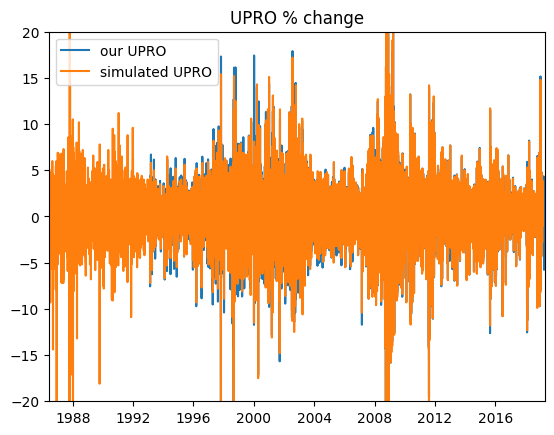

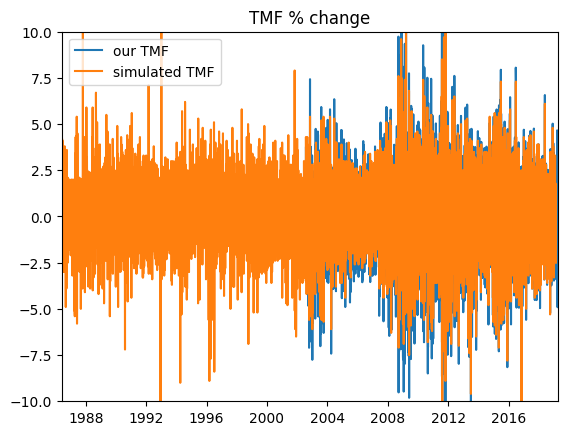

In [27]:
plt.plot(joined_df["UPRO_ours"], label="our UPRO")
plt.plot(joined_df["UPRO_sim"], label = "simulated UPRO")
plt.legend()
plt.title("UPRO % change")
plt.ylim(-20,20)
plt.xlim(6000,18000)
plt.show()

plt.plot(joined_df["TMF_ours"], label="our TMF")
plt.plot(joined_df["TMF_sim"], label = "simulated TMF")
plt.legend()
plt.title("TMF % change")
plt.xlim(6000,18000)
plt.ylim(-10,10)
plt.show()

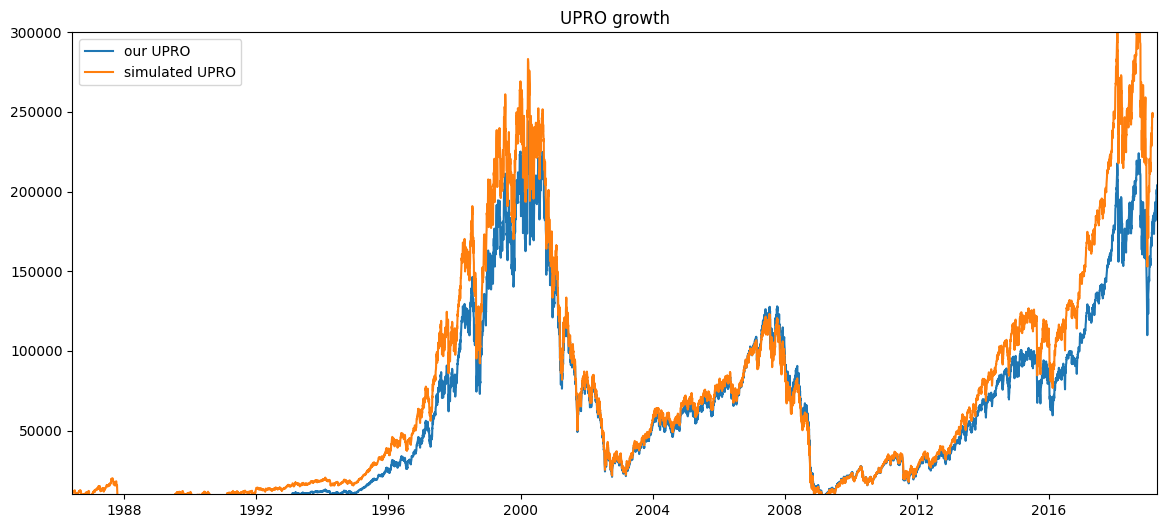

In [28]:
INIT = 10000

def growth(joined_df, init = 10000):
    # Set the first column as the index
    coeffs = 1 + joined_df / 100
    return INIT * coeffs.cumprod()

plt.figure(figsize=(14, 6))  # Adjust the width as needed
plt.plot(growth(joined_df, INIT)["UPRO_ours"], label="our UPRO")
plt.plot(growth(joined_df, INIT)["UPRO_sim"], label = "simulated UPRO")
plt.title("UPRO growth")
plt.legend()
plt.ylim(INIT,300000)
plt.xlim(6000,18000)
plt.show()

# TODO: starting year

In [30]:
def estimate_annual_expense_ratio(df, base_ticker, leverage_ticker, lev=3):
    """
    Estimates the annual expense ratio based on the comparison of simulated leveraged returns
    and actual ETF returns.

    Parameters:
    df (pd.DataFrame): DataFrame containing the historical prices.
    base_ticker (str): The ticker symbol for the base fund.
    leverage_ticker (str): The ticker symbol for the leveraged fund.
    lev (int): The leverage factor applied to the base ticker to achieve the leveraged ticker.

    Returns:
    float: The estimated annual expense ratio.
    """
    base_returns = df['Close', base_ticker].pct_change()
    leverage_returns = df['Close', leverage_ticker].pct_change()
    simulated_leverage_returns = base_returns * lev
    
    # Cumulative returns calculation
    actual_cumulative = (1 + leverage_returns).cumprod()[-1]
    simulated_cumulative = (1 + simulated_leverage_returns).cumprod()[-1]
    
    # Number of trading days
    n = len(df)
    
    # Estimate expense ratio
    expense_ratio_annual = 252 * (1 - (actual_cumulative / simulated_cumulative) ** (1/n))
    return expense_ratio_annual

# Example usage
base_ticker = 'SPY'
leverage_ticker = 'UPRO'
estimated_expense_ratio_annual = estimate_annual_expense_ratio(df, base_ticker, leverage_ticker)
print(f"Estimated Annual Expense Ratio: {estimated_expense_ratio_annual:.4f}")

# Now simulate UPRO including the estimated expense ratio
tickers = {base_ticker: leverage_ticker + '_simulated'}
upro_simulated_df = simulate_leverage_with_expense_ratio(df, tickers, lev=3, expense_ratio_annual=estimated_expense_ratio_annual)



def calculate_pct_change(df, ticker):
    """
    Calculates the daily percentage change of a given ticker's closing prices.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the closing prices.
    ticker (str): The ticker symbol of the asset.

    Returns:
    pd.Series: A Series containing the daily percentage changes of the asset.
    """
    if ('Close', ticker) in df.columns:
        pct_change_series = df['Close', ticker].pct_change() * 100  # Multiply by 100 to convert to percentage
        pct_change_series.name = f"{ticker}_pct_change"
        return pct_change_series
    else:
        return pd.Series([])  # Return an empty Series if the ticker is not found

def simulate_leverage_with_expense_ratio(df, tickers, lev=1, expense_ratio_annual=0):
    """
    Simulates the effect of leverage on the percentage changes of given tickers and adjusts for the expense ratio.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the closing prices.
    tickers (dict): A dictionary mapping ticker symbols to their leveraged equivalents.
    lev (int): The leverage factor.
    expense_ratio_annual (float): The annual expense ratio in decimal form (e.g., 0.0095 for 0.95%).

    Returns:
    pd.DataFrame: A DataFrame containing the simulated leveraged percentage changes.
    """
    pct_change_list = []
    daily_expense_ratio = expense_ratio_annual / 252  # Convert annual expense ratio to daily

    for index, letf in tickers.items():
        pct_change_series = calculate_pct_change(df, index)
        if not pct_change_series.empty:
            # Adjust for leverage and expense ratio
            adjusted_pct_change = (pct_change_series * lev) * (1 - daily_expense_ratio)
            adjusted_pct_change.name = f"{letf}_ours"  # Rename the Series for clarity
            pct_change_list.append(adjusted_pct_change)

    # Concatenate all the adjusted percentage change Series into a single DataFrame
    if pct_change_list:
        pct_change_df = pd.concat(pct_change_list, axis=1)
        pct_change_df.index.name = 'Date'  # Assuming the DataFrame's index is Date
        # Reset index to turn the Date index into a column
        pct_change_df.reset_index(inplace=True)
        return pct_change_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no tickers were found or provided



In [31]:
no_expense_ratio_simulated_upro = joined_df["UPRO_ours"]

yf.pdr_override()
upro_real_data = yf.download("UPRO")
upro_real_data



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-06-25,1.126250,1.210417,1.126250,1.205556,1.158101,2577600
2009-06-26,1.195278,1.213056,1.177361,1.199306,1.152096,13104000
2009-06-29,1.208333,1.236111,1.191389,1.233333,1.184784,8690400
2009-06-30,1.233333,1.243333,1.176389,1.203889,1.156499,17128800
2009-07-01,1.218472,1.252917,1.213611,1.216806,1.168908,12038400
...,...,...,...,...,...,...
2024-02-29,64.980003,65.589996,63.930000,64.940002,64.940002,6850400
2024-03-01,65.290001,66.949997,65.139999,66.769997,66.769997,6459000
2024-03-04,66.419998,67.279999,66.419998,66.510002,66.510002,3643300
